# Project TravelTide

## Introduction
TravelTide is a project aimed at analyzing customer sessions, bookings, and behaviors to understand key trends, preferences, and customer segmentation. The primary goal is to derive actionable insights for improved marketing, personalized offers, and increased customer satisfaction.

### Goals of the Project
- Analyze customer sessions, bookings, and purchasing behaviors.
- Segment customers using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering.
- Provide suggestions for targeted marketing and personalized perks based on segmentation.

In [ ]:
# Install the necessary libraries
!pip install psycopg2 pandas

import psycopg2
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Establishing a connection to PostgreSQL
conn = psycopg2.connect(
    dbname="TravelTide",  # название базы данных
    user="Test",  # пользователь
    password="bQNxVzJL4g6u",  # пароль
    host="ep-noisy-flower-846766.us-east-2.aws.neon.tech",  # хост базы данных
    port="5432"  # порт по умолчанию для PostgreSQL
)

# Request to get data
query = """
WITH session_based AS (
    SELECT
        s.session_id,
        s.user_id,
        s.trip_id,
        s.session_start,
        s.session_end,
        s.page_clicks,
        s.flight_discount,
        s.flight_discount_amount,
        s.hotel_discount,
        s.hotel_discount_amount,
        s.flight_booked,
        s.hotel_booked,
        s.cancellation,
        EXTRACT(EPOCH FROM (s.session_end - s.session_start)) AS session_duration,
        f.trip_id,
        f.origin_airport,
        f.destination,
        f.destination_airport,
        f.seats,
        f.return_flight_booked,
        f.departure_time,
        f.return_time,
        f.checked_bags,
        f.trip_airline,
        f.destination_airport_lat,
        f.destination_airport_lon,
        f.base_fare_usd,
        h.trip_id,
        h.hotel_name,
        h.nights,
        h.rooms,
        h.check_in_time,
        h.check_out_time,
        h.hotel_per_room_usd AS hotel_price_per_room_night_usd,
        u.birthdate,
        u.gender,
        u.married,
        u.has_children,
        u.home_country,
        u.home_city,
        u.home_airport,
        u.home_airport_lat,
  			u.home_airport_lon,
        u.sign_up_date
  from sessions s
  left join users u
  on s.user_id = u.user_id
  left join flights f
  on s.trip_id = f.trip_id
  left join hotels h
  on s.trip_id = h.trip_id
  WHERE s.user_id IN (SELECT user_id
                     FROM sessions
                     WHERE session_start > '2023-01-04'
                     GROUP BY user_id
                     HAVING COUNT(*) > 7)

)
SELECT *
FROM session_based;
"""

# Loading data into a DataFrame
df = pd.read_sql(query, conn)

# Closing the connection
conn.close()

# Let's check what the data looks like
df.head()

<ipython-input-1-a80e57acd91b>:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,...,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date
0,542918-e26d0641558e4b86a33a242dd0b5587c,542918,542918-2c94de61e282444480c61c676e5188f2,2023-01-21 20:14:00,2023-01-21 20:16:21,19,True,0.10,False,NaN,...,1988-01-16,F,True,True,canada,toronto,YYZ,43.677,-79.631,2023-01-20
1,539320-563701cd4360453d8627fdc7896c4a5a,539320,539320-6128d40ec84e4bc1a98a12df7cd5fe14,2023-04-24 15:41:00,2023-04-24 15:42:47,14,False,NaN,False,NaN,...,1983-03-12,F,False,False,usa,birmingham,BHM,33.563,-86.753,2023-01-19
2,593385-eb3a98579fbb41c584f8450b49545fa5,593385,593385-e158202c7504428f99cc99daa2b7355f,2023-04-24 23:47:00,2023-04-24 23:49:09,17,False,NaN,True,0.1,...,1978-11-25,F,True,True,usa,new york,JFK,40.640,-73.779,2023-02-14
3,518751-58953f6c91fe4991aea6b9dadd24ce71,518751,518751-d5522e6eff784dcb9702d712ec54e719,2023-01-19 10:29:00,2023-01-19 10:31:45,22,False,NaN,False,NaN,...,1991-01-17,F,False,False,usa,indianapolis,IND,39.717,-86.294,2023-01-09
4,577255-ef73969ef5c449a79e54c123d6fd4a49,577255,577255-dcd5bdb3f2c0480e87fa0e0e9bbad10d,2023-02-06 18:47:00,2023-02-06 18:49:39,21,True,0.05,False,NaN,...,1978-06-05,F,False,False,usa,las vegas,LSV,36.236,-115.034,2023-02-06


In [ ]:
# Adding age column
current_year = datetime.now().year
df['age'] = current_year - pd.to_datetime(df['birthdate']).dt.year

# Defining user groups
seniors = df[
    (df['age'] >= 60)
]
business_travelers = df[
    (df['seats'] == 1) &
    (df['has_children'] == False) &
    (df['trip_airline'].notnull()) &
    (df['nights'] <= 3)
]
families = df[
    (df['married'] == True) &
    (df['has_children'] == True) &
    (df['seats'] > 1)
]
childless_couples = df[
    (df['married'] == True) &
    (df['has_children'] == False)
]
single_travelers = df[
    (df['married'] == False) &
    (df['has_children'] == False) &
    (df['seats'] == 1)
]

# Counting users in each group
group_counts = {
    'Seniors': len(seniors),
    'Business Travelers': len(business_travelers),
    'Families': len(families),
    'Childless Couples': len(childless_couples),
    'Single Travelers': len(single_travelers)
}
print("\nUser Group Counts:")
print(group_counts)


User Group Counts:
{'Seniors': 3104, 'Business Travelers': 5675, 'Families': 457, 'Childless Couples': 13168, 'Single Travelers': 5531}


In [ ]:
# Defining user groups
seniors = df[(df['age'] >= 60)]
business_travelers = df[(df['seats'] == 1) & (df['has_children'] == False) & (df['trip_airline'].notnull()) & (df['nights'] <= 3)]
families = df[(df['married'] == True) & (df['has_children'] == True) & (df['seats'] > 1)]
childless_couples = df[(df['married'] == True) & (df['has_children'] == False)]
single_travelers = df[(df['married'] == False) & (df['has_children'] == False) & (df['seats'] == 1)]

# Counting users in each group
group_counts = {
    'Seniors': len(seniors),
    'Business Travelers': len(business_travelers),
    'Families': len(families),
    'Childless Couples': len(childless_couples),
    'Single Travelers': len(single_travelers)
}
print("\nUser Group Counts:")
print(group_counts)

# Function to analyze the impact of discounts on bookings
def analyze_discount_impact(df, group_name, discount_type, booking_type):

    # Grouping data by discount type and calculating mean booking rate
    impact = df.groupby(discount_type)[booking_type].mean()
    print(f"The Impact of {discount_type} on {group_name}:")
    print(impact)

# Analyzing the impact of flight and hotel discounts for different traveler groups
# Business Travelers
analyze_discount_impact(business_travelers, "Business Travelers", 'flight_discount', 'flight_booked')
analyze_discount_impact(business_travelers, "Business Travelers", 'hotel_discount', 'hotel_booked')

# Families
analyze_discount_impact(families, "Families", 'flight_discount', 'flight_booked')
analyze_discount_impact(families, "Families", 'hotel_discount', 'hotel_booked')

# Seniors
analyze_discount_impact(seniors, "Seniors", 'flight_discount', 'flight_booked')
analyze_discount_impact(seniors, "Seniors", 'hotel_discount', 'hotel_booked')

# Childless Couples
analyze_discount_impact(childless_couples, "Childless Couples", 'flight_discount', 'flight_booked')
analyze_discount_impact(childless_couples, "Childless Couples", 'hotel_discount', 'hotel_booked')

# Single Travelers
analyze_discount_impact(single_travelers, "Single Travelers", 'flight_discount', 'flight_booked')
analyze_discount_impact(single_travelers, "Single Travelers", 'hotel_discount', 'hotel_booked')


User Group Counts:
{'Seniors': 3104, 'Business Travelers': 5675, 'Families': 457, 'Childless Couples': 13168, 'Single Travelers': 5531}
The Impact of flight_discount on Business Travelers:
flight_discount
False    1.0
True     1.0
Name: flight_booked, dtype: float64
The Impact of hotel_discount on Business Travelers:
hotel_discount
False    1.0
True     1.0
Name: hotel_booked, dtype: float64
The Impact of flight_discount on Families:
flight_discount
False    1.0
True     1.0
Name: flight_booked, dtype: float64
The Impact of hotel_discount on Families:
hotel_discount
False    0.783133
True     0.800000
Name: hotel_booked, dtype: float64
The Impact of flight_discount on Seniors:
flight_discount
False    0.095426
True     0.161972
Name: flight_booked, dtype: float64
The Impact of hotel_discount on Seniors:
hotel_discount
False    0.140344
True     0.254630
Name: hotel_booked, dtype: float64
The Impact of flight_discount on Childless Couples:
flight_discount
False    0.305857
True     0.2

1. Business Travelers and Single Travelers always book flights and hotels regardless of discounts, indicating that discounts do not influence their booking decisions.
2. Families prefer hotel discounts, as seen by a higher average booking rate with discounts. Flight discounts, however, do not influence their decision.
3. Seniors are highly sensitive to discounts, both on flights and hotels. Their booking rates significantly increase when discounts are offered.
4. Childless Couples are more influenced by hotel discounts rather than flight discounts, suggesting they are more cost-sensitive when it comes to accommodation.

The Impact of flight_discount on All Users:
flight_discount
False    16.392925
True     23.588152
Name: page_clicks, dtype: float64
The Impact of hotel_discount on All Users:
hotel_discount
False    16.244113
True     26.672600
Name: page_clicks, dtype: float64
Impact of discounts on clicks for all user groups (flights):
flight_discount
False    16.392925
True     23.588152
Name: page_clicks, dtype: float64


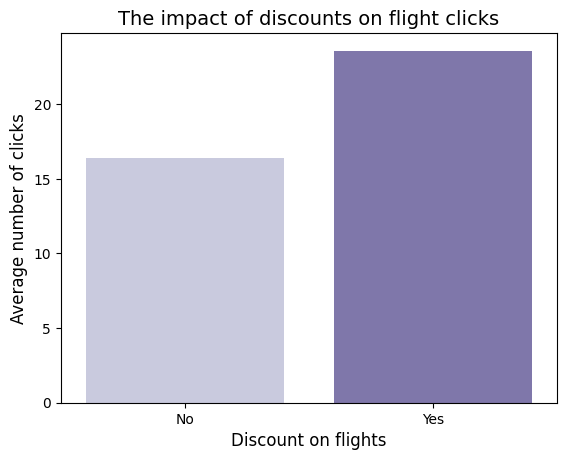

Impact of discounts on clicks for all user groups (hotels):
hotel_discount
False    16.244113
True     26.672600
Name: page_clicks, dtype: float64


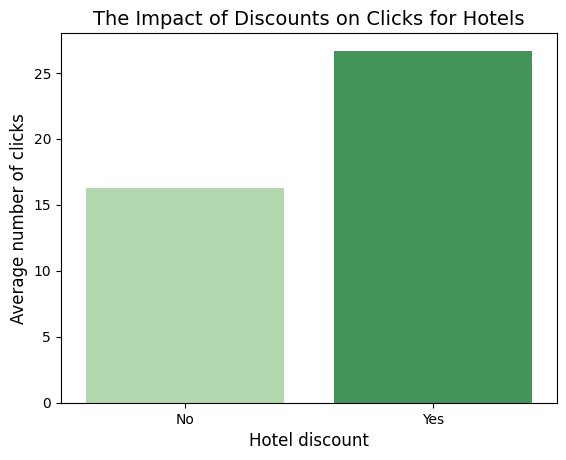

Average clicks by user groups and discount types:
   flight_discount  hotel_discount  avg_page_clicks
0            False           False        16.372226
1            False            True        16.540286
2             True           False        15.598946
3             True            True        53.577824


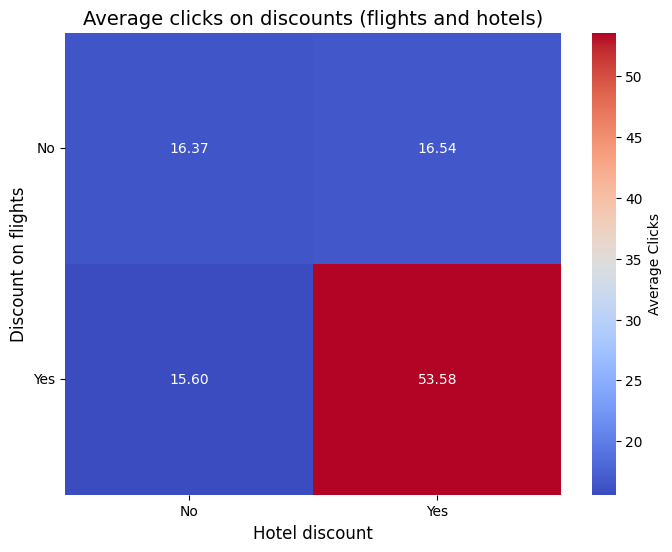

In [ ]:
# Impact of discounts on page clicks for all user groups
analyze_discount_impact(df, "All Users", 'flight_discount', 'page_clicks')
analyze_discount_impact(df, "All Users", 'hotel_discount', 'page_clicks')

# Function to generate a bar plot for discount impacts
def plot_discount_impact(impact, title, xlabel, xtick_labels, palette):
    """
    Function to generate bar plots showing the impact of discounts on clicks.

    Parameters:
    impact (Series): Series with discount impact data.
    title (str): Title for the plot.
    xlabel (str): Label for the x-axis.
    xtick_labels (list): Labels for the x-axis categories.
    palette (str): Color palette for the plot.
    """
    sns.barplot(
    x=impact.index,
    y=impact.values,
    hue=impact.index,
    palette=palette,
    legend=False
)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Average number of clicks", fontsize=12)
    plt.xticks(ticks=[0, 1], labels=xtick_labels)
    plt.show()

# Plotting impact of discounts on clicks for flights and hotels
flight_discount_impact_clicks = df.groupby('flight_discount')['page_clicks'].mean()
print("Impact of discounts on clicks for all user groups (flights):")
print(flight_discount_impact_clicks)
plot_discount_impact(flight_discount_impact_clicks, "The impact of discounts on flight clicks", "Discount on flights", ["No", "Yes"], "Purples")

hotel_discount_impact_clicks = df.groupby('hotel_discount')['page_clicks'].mean()
print("Impact of discounts on clicks for all user groups (hotels):")
print(hotel_discount_impact_clicks)
plot_discount_impact(hotel_discount_impact_clicks, "The Impact of Discounts on Clicks for Hotels", "Hotel discount", ["No", "Yes"], "Greens")

# Combined impact of discounts on clicks by user groups
clicks_grouped = df.groupby(['flight_discount', 'hotel_discount']).agg(avg_page_clicks=('page_clicks', 'mean')).reset_index()
print("Average clicks by user groups and discount types:")
print(clicks_grouped)

pivot_table = clicks_grouped.pivot(index='flight_discount', columns='hotel_discount', values='avg_page_clicks')
plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_table,
    annot=True, cmap="coolwarm", fmt=".2f",
    cbar_kws={'label': 'Average Clicks'}
)
plt.title("Average clicks on discounts (flights and hotels)", fontsize=14)
plt.xlabel("Hotel discount", fontsize=12)
plt.ylabel("Discount on flights", fontsize=12)
plt.xticks(ticks=[0.5, 1.5], labels=["No", "Yes"])
plt.yticks(ticks=[0.5, 1.5], labels=["No", "Yes"], rotation=0)
plt.show()

**Detailed Summary:**

- Discounts on **flights** increase the average number of clicks from **16.39** (no discount) to **23.59**, which is an increase of approximately **44%**. This shows that users are significantly more likely to engage when there is a discount on flights.
- Discounts on **hotels** show an even larger impact, increasing average clicks from **16.24** (no discount) to **26.67**, representing an increase of about **64%**. Users appear to be highly responsive to discounts on hotels.


- When considering **combined discounts**:
  - **No discounts on both flights and hotels** result in **16.37** average clicks.
  - **Discount only on hotels** increases clicks to **16.54**, a small improvement.
  - **Discount only on flights** slightly decreases clicks to **15.60**.
  - **Discounts on both flights and hotels** lead to a significant rise in clicks to **53.58**, which is over **3 times** higher compared to any other combination.

This suggests that combined offers are most attractive to users, leading to substantially higher engagement. Single discounts also have an effect, but their impact is much less pronounced compared to when both types of discounts are offered together.

<ipython-input-5-4ae8f3ce11a5>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_vs_booking = df.groupby('session_category')['flight_booked'].mean()
<ipython-input-5-4ae8f3ce11a5>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=session_vs_booking.index, y=session_vs_booking.values, palette="viridis")


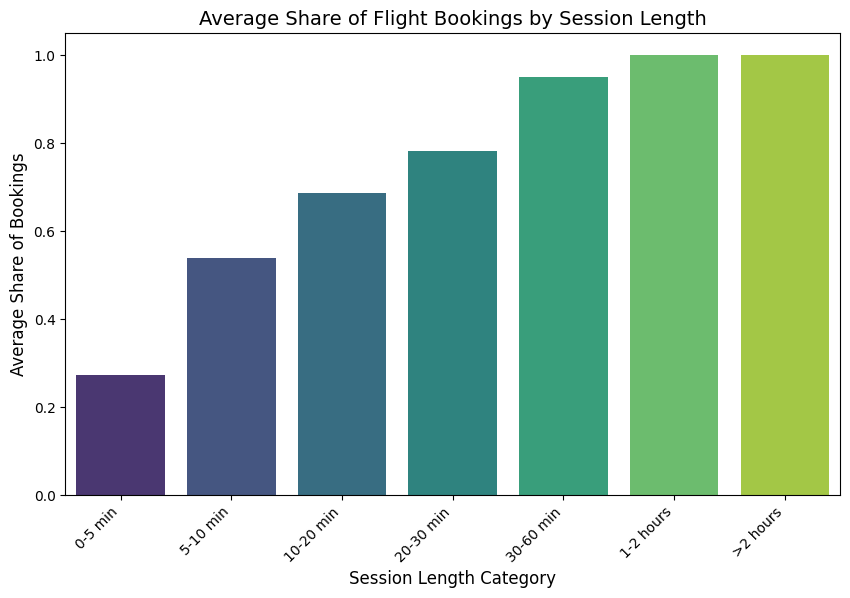

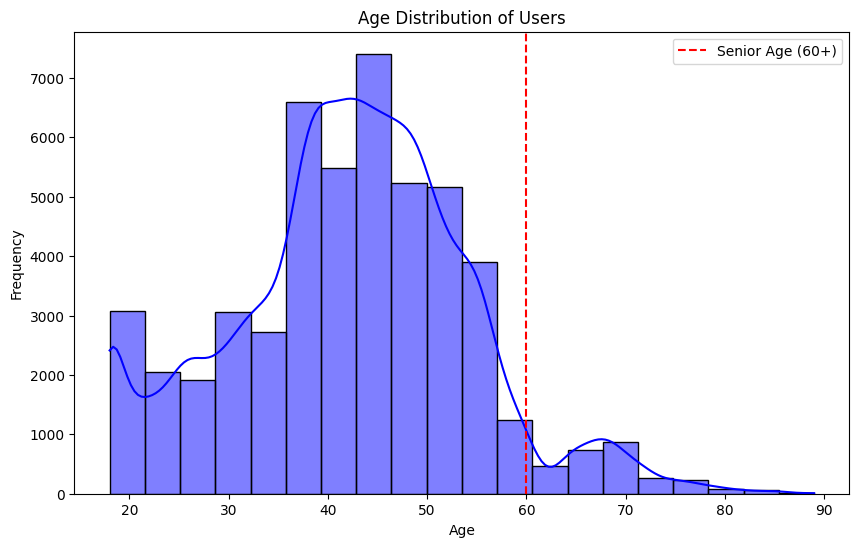

In [ ]:
# Enhanced visualization for session length vs bookings
bins = [0, 300, 600, 1200, 1800, 3600, 7200, 10000]  # Session length ranges in seconds
labels = ["0-5 min", "5-10 min", "10-20 min", "20-30 min", "30-60 min", "1-2 hours", ">2 hours"]
df['session_category'] = pd.cut(df['session_duration'], bins=bins, labels=labels, right=False)

session_vs_booking = df.groupby('session_category')['flight_booked'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=session_vs_booking.index, y=session_vs_booking.values, palette="viridis")
plt.title("Average Share of Flight Bookings by Session Length", fontsize=14)
plt.xlabel("Session Length Category", fontsize=12)
plt.ylabel("Average Share of Bookings", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# Age group distribution visualization with vertical line
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True, color='blue')
plt.axvline(x=60, color='red', linestyle='--', label='Senior Age (60+)')
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()


1. **Impact of Session Length on Bookings**: There is a clear positive correlation between session length and booking probability. Users with shorter sessions (0-5 minutes) are much less likely to book a flight compared to users with longer sessions. Sessions over 30 minutes have booking probabilities approaching 100%, indicating that longer user engagement significantly increases the likelihood of bookings. This suggests a potential to improve user retention for those with shorter sessions through targeted offers or recommendations.

2. **Age Distribution**: The user age distribution is roughly normal, with a peak in the 30-40 age range. There are significantly fewer users aged 60 and above, suggesting that seniors make up a smaller proportion of the overall user base. This indicates an opportunity to design marketing strategies specifically targeted at users over 60 to increase their engagement and presence on the platform.

   age_group  has_children  user_count    group_type
0      18-35         False         514   only_hotels
1      18-35          True         216   only_hotels
2      36-55         False         905   only_hotels
3      36-55          True         526   only_hotels
4        55+         False         250   only_hotels
5        55+          True          84   only_hotels
6      18-35         False         252  only_flights
7      18-35          True          94  only_flights
8      36-55         False         945  only_flights
9      36-55          True         449  only_flights
10       55+         False          97  only_flights
11       55+          True          36  only_flights


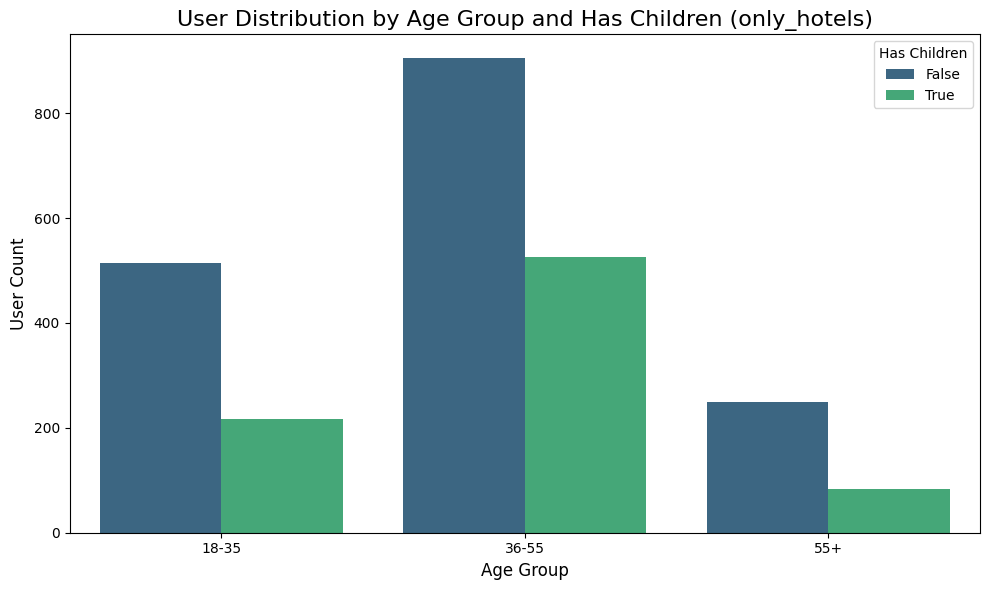

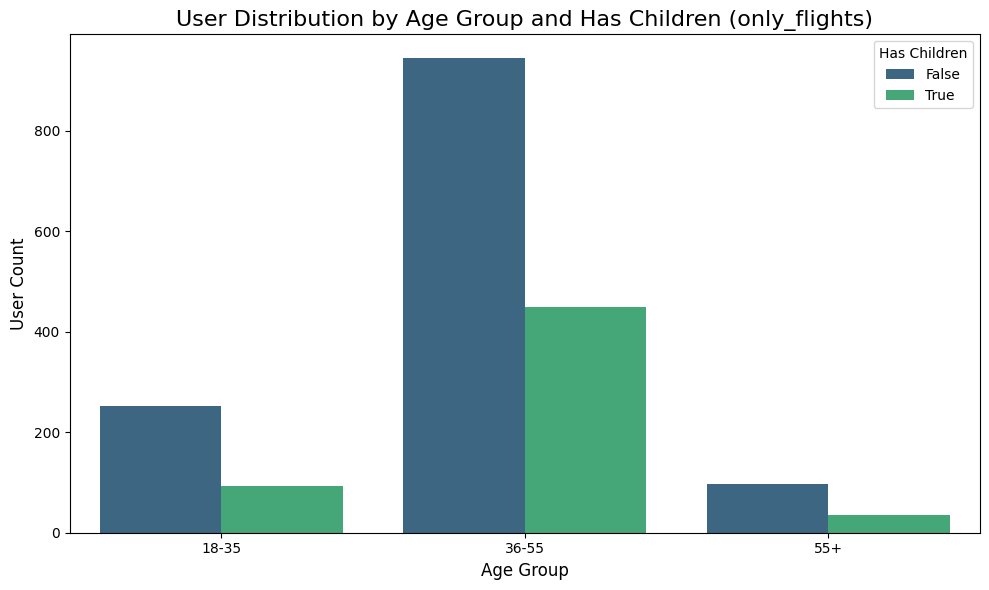

In [ ]:
# Ensure date of birth is in datetime format
df['birthdate'] = pd.to_datetime(df['birthdate'])

# Age calculation
df['age'] = (pd.Timestamp.now() - df['birthdate']).dt.days // 365

# Filtering data for only hotel or flight bookings
only_hotels = df[(df['hotel_booked'] == True) & (df['flight_booked'] == False)].copy()
only_flights = df[(df['flight_booked'] == True) & (df['hotel_booked'] == False)].copy()

# Function for classifying age groups
def classify_age_group(age):
    if 18 <= age <= 35:
        return '18-35'
    elif 36 <= age <= 55:
        return '36-55'
    else:
        return '55+'

# Applying the function to classify age groups
only_hotels['age_group'] = only_hotels['age'].apply(classify_age_group)
only_flights['age_group'] = only_flights['age'].apply(classify_age_group)

# Counting the number of users in each group
hotels_grouped = only_hotels.groupby(['age_group', 'has_children']).size().reset_index(name='user_count')
hotels_grouped['group_type'] = 'only_hotels'

flights_grouped = only_flights.groupby(['age_group', 'has_children']).size().reset_index(name='user_count')
flights_grouped['group_type'] = 'only_flights'

# Combining the results
result = pd.concat([hotels_grouped, flights_grouped], ignore_index=True)

# Output of results
print(result)

# Function to visualize age group distribution
def plot_age_group_distribution(data, group_type):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=data,
        x='age_group',
        y='user_count',
        hue='has_children',
        palette='viridis'
    )
    plt.title(f"User Distribution by Age Group and Has Children ({group_type})", fontsize=16)
    plt.xlabel("Age Group", fontsize=12)
    plt.ylabel("User Count", fontsize=12)
    plt.legend(title="Has Children", loc='upper right')
    plt.tight_layout()
    plt.show()

# Creating separate graphs for only_hotels and only_flights
for group_type in result['group_type'].unique():
    subset = result[result['group_type'] == group_type]
    plot_age_group_distribution(subset, group_type)


### Insights from the graphs:

1. **Distribution of users who booked only hotels**:
- Most of the users who booked only hotels are in the **36-55** age group.
- There is a large number of users in this age group who **have children**, suggesting that this group is more focused on family travel and comfortable accommodations.
- There is also a significant number of users in the **18-35** age group, but mostly **without children**. This may mean that younger users are more likely to travel alone or in couples.

2. **Distribution of users who booked only flights**:
- Similar to hotel only bookings, most of the users in the **36-55** age group also have children, but the overall number of users here is lower compared to hotel only bookings.
- In the **18-35** age group, the majority of users are **without children**, which matches the typical profile of a younger traveler who tends to choose flights, perhaps for shorter, less burdensome trips.

### Key findings:
- The **36-55** age group with children is the dominant group for booking **hotels only**, suggesting that these users value comfort and convenience for family vacations.
- **Younger users (18-35)** without children tend to book **flights only**, suggesting that they prefer to save on accommodation or do not require hotel accommodation.
- This can help with more effective targeting - for example, marketing offers to the **36-55** age group with children could include hotel packages, while for **18-35** it is preferable to focus on affordable flights and adventure tours.

In [ ]:
# Calculate the proportion of orders with a discount (discount_flight_proportion) for each user
df["flight_discount_used"] = np.where(df["flight_discount"] > 0, 1, 0)  # 1, if there was a discount
flight_discount_proportion = df.groupby("user_id")["flight_discount_used"].mean().reset_index()
flight_discount_proportion.rename(columns={"flight_discount_used": "discount_flight_proportion"}, inplace=True)

# Calculate the average flight discount for each user
average_flight_discount = df.groupby("user_id")["flight_discount_amount"].mean().reset_index()
average_flight_discount.rename(columns={"flight_discount_amount": "average_flight_discount"}, inplace=True)

# Scaling the session_duration indicator using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df["scaled_ADS_per_km"] = scaler.fit_transform(df[["session_duration"]])

# Combine metrics into one DataFrame
user_metrics = (
    flight_discount_proportion
    .merge(average_flight_discount, on="user_id", how="left")
    .merge(df.groupby("user_id")["scaled_ADS_per_km"].mean().reset_index(), on="user_id", how="left")
)

# Calculation of composite_score_weighted_sum
weights = [0.5, 0.3, 0.2]  # Setting weights
user_metrics["composite_score_weighted_sum"] = (
    user_metrics["discount_flight_proportion"] * weights[0] +
    user_metrics["average_flight_discount"] * weights[1] +
    user_metrics["scaled_ADS_per_km"] * weights[2]
)

# Replace inf and -inf with NaN and fill NaN with 0
user_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
user_metrics.fillna(0, inplace=True)

# User Ranking
user_metrics["rank_weighted_sum"] = user_metrics["composite_score_weighted_sum"].rank(ascending=False).astype(int)

# Customer segmentation using np.select()
conditions_weighted = [
    user_metrics["rank_weighted_sum"] <= len(user_metrics) * 0.2,
    user_metrics["rank_weighted_sum"] <= len(user_metrics) * 0.6
]
choices = ["High Value", "Medium Value"]
user_metrics["segment_weighted_sum"] = np.select(conditions_weighted, choices, default="Low Value")

# Result output
print(user_metrics.head(10))
print(user_metrics.describe())

# Export the user_metrics DataFrame to a CSV file
user_metrics.to_csv('user_metrics.csv', index=False)  # Save the DataFrame as a CSV file


   user_id  discount_flight_proportion  average_flight_discount  \
0    23557                    0.166667                 0.150000   
1    94883                    0.083333                 0.100000   
2   101486                    0.384615                 0.075000   
3   101961                    0.250000                 0.133333   
4   106907                    0.142857                 0.150000   
5   118043                    0.307692                 0.166667   
6   120851                    0.384615                 0.175000   
7   125845                    0.230769                 0.150000   
8   133058                    0.076923                 0.150000   
9   149058                    0.166667                 0.050000   

   scaled_ADS_per_km  composite_score_weighted_sum  rank_weighted_sum  \
0           0.040281                      0.136390               2955   
1           0.007807                      0.073228               4656   
2           0.090845                      0

Correlation matrix of key metrics:
                 flight_discount  hotel_discount  page_clicks  flight_booked  \
flight_discount         1.000000        0.096992     0.128419      -0.001749   
hotel_discount          0.096992        1.000000     0.167319       0.049533   
page_clicks             0.128419        0.167319     1.000000       0.401604   
flight_booked          -0.001749        0.049533     0.401604       1.000000   
hotel_booked            0.006357        0.060185     0.404191       0.795523   

                 hotel_booked  
flight_discount      0.006357  
hotel_discount       0.060185  
page_clicks          0.404191  
flight_booked        0.795523  
hotel_booked         1.000000  


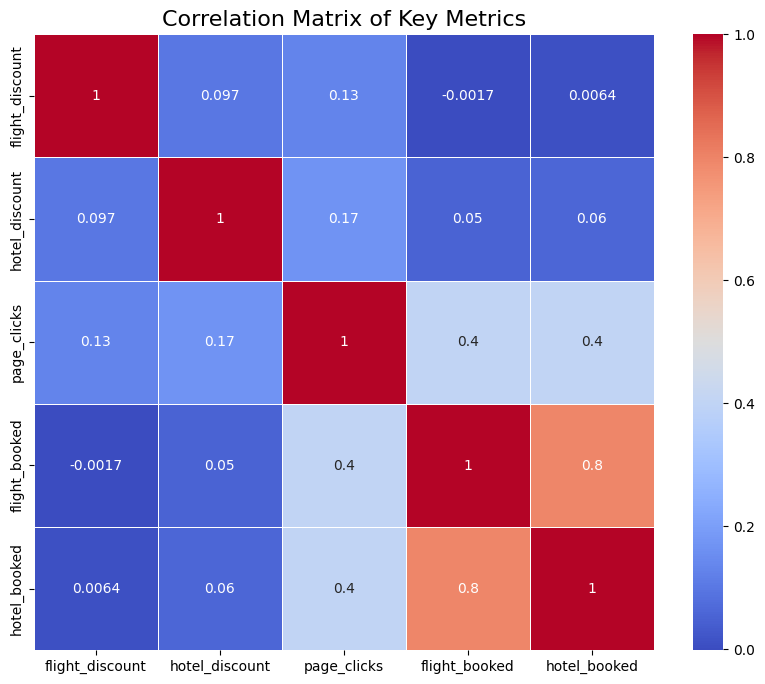

In [ ]:
# Correlation analysis between metrics
correlation_matrix = df[['flight_discount', 'hotel_discount', 'page_clicks', 'flight_booked', 'hotel_booked']].corr()
print("Correlation matrix of key metrics:")
print(correlation_matrix)

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Key Metrics", fontsize=16)
plt.show()

**Summary of Findings from Correlation Matrix**:

1. **Weak Correlation between Discounts**:
   - The correlation between `flight_discount` and `hotel_discount` is **0.097**. This suggests that discounts on flights and hotels are not strongly related, meaning a discount on one does not imply a discount on the other.

2. **Impact of Discounts on Page Clicks**:
   - `page_clicks` has a weak positive correlation with both `flight_discount` (**0.128**) and `hotel_discount` (**0.167**). This indicates that discounts have some positive effect on user engagement, but it's not substantial.

3. **Flight and Hotel Bookings Correlation**:
   - `flight_booked` and `hotel_booked` have a high positive correlation of **0.796**, suggesting that users who book flights are also likely to book hotels. This implies a strong relationship between these types of bookings.

4. **Page Clicks and Bookings**:
   - `page_clicks` has a moderate correlation with both `flight_booked` (**0.402**) and `hotel_booked` (**0.404**). This suggests that increased engagement (more page clicks) is associated with higher booking rates, but it's not the only determining factor.

### Conclusion:
- **Flight and Hotel Discounts** have a limited direct effect on increasing engagement or driving bookings. More attractive offers or other marketing strategies may be needed to boost their effectiveness.
- **Flight and Hotel Bookings** are highly related, indicating that bundling these offerings or creating packages could be beneficial for increasing sales.
- **User Engagement (Page Clicks)** moderately affects bookings, suggesting that more interaction with the website leads to more bookings, but additional factors also play a role in decision-making.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Convert 'session_start' to datetime
df['session_start'] = pd.to_datetime(df['session_start'])

# Current date
current_date = datetime.now()

# Aggregate data by user_id
df_aggregated = df.groupby('user_id').agg(
    recency=('session_start', lambda x: (current_date - x.max()).days),  # Number of days since last session
    frequency=('session_id', 'count'),  # Number of sessions
    monetary=('flight_discount_amount', 'sum')  # Total of all discounts
).reset_index()

# Fill in the missing values ​​for Monetary and Recency
df_aggregated['monetary'] = df_aggregated['monetary'].fillna(0)
df_aggregated['recency'] = df_aggregated['recency'].fillna(df_aggregated['recency'].max())

# We rank users by each RFM parameter (from 1 to 5)
df_aggregated['R_score'] = pd.qcut(df_aggregated['recency'], 5, labels=[5, 4, 3, 2, 1])
df_aggregated['F_score'] = pd.cut(df_aggregated['frequency'], bins=5, labels=[1, 2, 3, 4, 5])
df_aggregated['M_score'] = pd.cut(df_aggregated['monetary'], bins=5, labels=[1, 2, 3, 4, 5])

# Combine RFM estimates into one line
df_aggregated['RFM'] = df_aggregated['R_score'].astype(str) + df_aggregated['F_score'].astype(str) + df_aggregated['M_score'].astype(str)

# Applying standardization to clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_aggregated[['recency', 'frequency', 'monetary']])

# Using K-Means for Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_aggregated['Cluster'] = kmeans.fit_predict(scaled_data)

# Segmenting customers
segments = {
    'Champions': df_aggregated[df_aggregated['RFM'] == '555'],
    'Loyal Customers': df_aggregated[df_aggregated['RFM'].str[1] == '5'],
    'At Risk': df_aggregated[(df_aggregated['RFM'].str[0] == '1') & (df_aggregated['RFM'].str[1:] != '11')],
    'Lost': df_aggregated[df_aggregated['RFM'] == '111']
}

# We display the results
print(df_aggregated[['user_id', 'RFM', 'Cluster']].head())
print(segments)


# Create an Excel file with multiple sheets
with pd.ExcelWriter('user_segments.xlsx', engine='openpyxl') as writer:
    df_aggregated.to_excel(writer, sheet_name='All Users', index=False)  # All users
    segments['Champions'].to_excel(writer, sheet_name='Champions', index=False)  # Champions
    segments['Loyal Customers'].to_excel(writer, sheet_name='Loyal Customers', index=False)  # Loyal Customers
    segments['At Risk'].to_excel(writer, sheet_name='At Risk', index=False)  # At Risk
    segments['Lost'].to_excel(writer, sheet_name='Lost', index=False)  # Lost



   user_id  RFM  Cluster
0    23557  541        2
1    94883  241        2
2   101486  552        2
3   101961  342        2
4   106907  551        2
{'Champions': Empty DataFrame
Columns: [user_id, recency, frequency, monetary, R_score, F_score, M_score, RFM, Cluster]
Index: [], 'Loyal Customers':      user_id  recency  frequency  monetary R_score F_score M_score  RFM  \
2     101486      500         13      0.30       5       5       2  552   
4     106907      491         14      0.15       5       5       1  551   
5     118043      503         13      0.50       5       5       3  553   
6     120851      536         13      0.70       2       5       3  253   
7     125845      498         13      0.30       5       5       2  552   
8     133058      501         13      0.15       5       5       1  551   
14    167852      584         13      0.30       1       5       2  152   
17    175032      497         14      0.30       5       5       2  552   
23    195192      550    

### **Customer Segments**:
1. **Champions**: This segment is empty, indicating that there are no users who scored the highest on each RFM parameter (high frequency, low recency, and high monetary value). This may imply a gap in achieving highly engaged and loyal customers.

2. **Loyal Customers**: This segment includes users with high frequency (`F_score` = `5`), indicating they are loyal to the company. There are 16 users in this segment, suggesting a group of highly active users. The recency values vary, showing that while they have interacted frequently, the time since their last interaction differs.

3. **At Risk**: These users have high recency scores (`R_score` = `1`), indicating they have not interacted with the product recently. There are 486 users in this segment, which shows a significant number of customers who might be at risk of churn. It's essential to create targeted campaigns to re-engage them.

4. **Lost**: These users have the lowest values for all three RFM parameters (`RFM = 111`). They show no signs of activity, indicating a very low likelihood of returning. There are 680 users in this segment, representing a large group that may be challenging to re-engage.

### **Cluster Segmentation Analysis**:
- The users were divided into clusters (`Cluster`), which adds additional layers of segmentation beyond the RFM analysis. This helps create more targeted strategies for each group.
- Cluster-based segmentation, along with RFM scores, allows for a more refined understanding of user behavior.

### **Recommendations**:
1. **Activate Champions**:
   - Since the `Champions` segment is empty, analyze why users are not reaching the highest engagement levels. Consider enhancing loyalty programs or offering more incentives to encourage increased frequency and higher monetary value.

2. **Focus on Loyal Customers**:
   - Keep this group actively engaged through exclusive offers, bonuses, or improved conditions. They have a high potential for long-term retention and can be encouraged to engage even more frequently.

3. **Prevent Churn for At Risk Customers**:
   - Offer special incentives to bring these users back. Targeted marketing campaigns focusing on their needs might be effective in retaining them.

4. **Approach for Lost Customers**:
   - Analyze this group to understand why they left and identify areas for improvement. However, efforts to re-engage this group should be minimal as their likelihood of returning is very low.

